# Resumo

**Fonte:**[Brasil.IO - COVID-19 Casos](https://brasil.io/dataset/covid19/caso/)
<br>
Dados até 04/11/2020
<br>
<i>A analise visa somente descrever os dados apresentados considerando-os verdadeiros e aconselhando maiores estudos sobre a quantidade de teste realizada em cada região.</i>

<p>    Mais de 60% dos casos ocorridos no Brasil são do Nordeste e Suldeste, essa diferença entre as regiões ocorre devido a ditribuição da população do Brasil, quando se fala de mortes esse número sobre para 71%, já esta diferença se deve a quantidade de teste não realizada, em assintomáticos. Considerando o percentural de casos confirmados pelo total da população estimada o Norte do país é o mais afetado com mais de 4% da população local infectada, indicando que ainda há um terreno muito grande para  a infecção crescer ainda.
</p>
<img src="img/p1.png"/>
Destaque para SP, MG e BA. SP por ser o lider em casos confirmados absolutos, MG e BA pela recente escalada nos casos.
<img src="img/escalada.png"/>

<p>     Os dados indicam que as confirmações sofrem dois tipos de influencia uma está relacionada a <b>uma redução grande no número de confirmações no fim de semana</b> e outra indica um <b>represamento maior ocorrido em épocas diferentes</b> em cada região, em SC houve a confirmação de aproximadamente 31 mil casos em apenas 1 dia, isso representa 11,51% do total de casos 268 mil confirmados em 239 dias.
</p>
<img src="img/p2.png"/>
<p>     É possível notar uma redução consistente nos casos confirmados após o inverno, tanto nos casos represados quanto no número total de novos casos até outubro, onde aparentemente há uma estagnação no número de casos em níveis maiores que o do incício da pandemia, somando isso ao número de potenciais infecctados (mais de 97% ainda não pegou) nas regiões mais povoadas do Brasil e ao fato de estarmos testando menos do pouco que já testávamos não á como concluir muita coisa dos dados confirmados. 
<img src="img/p3.png"/>
</p>


## Organizando Data Frames (DF)

##  Organizando DF pincipal

In [1]:
colunas = ['data',
 'uf',
 'municipio',
 'tipo_de_local',
 'confirmacoes',
 'mortes',
 'ordenacao',
 'ultimo',
 'pupolacao_estimada_2019',
 'pupolacao_estimada',
 'ibge_codigo',
 'confirmados_por_100k_hab',
 'mortes_por_confirmados']

regioes = {'1':'norte','2':'nordeste','3':'suldeste','4':'sul','5':'centrooeste'}

In [2]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import ticker
from matplotlib.patches import Ellipse
dados = pd.read_csv('base_covid/caso.csv',header=0,names=colunas)
dados.tipo_de_local = dados.tipo_de_local.map({'state':'estado','city':'cidade'})
dados['mes'] = dados.data.str[0:-3]
dados.data = pd.to_datetime(dados.data)
dados['cod_regiao'] = dados.ibge_codigo.apply(lambda x: str(x)[0:1])
dados['regiao'] = dados['cod_regiao'].map(regioes)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_palette('tab10')

## Criando DF dos estados

In [5]:
df_slice_estados = dados.query("tipo_de_local == 'estado'").copy()
df_slice_estados.drop(['municipio','tipo_de_local'], axis=1, inplace=True)
df_estados_agrupados_mes_uf_regiao = df_slice_estados.groupby(['mes','uf','regiao']).mean()['confirmados_por_100k_hab'].to_frame()
df_estados_agrupados_mes_uf_regiao.columns = ['media_'+df_estados_agrupados_mes_uf_regiao.columns[0]]
df_estados_agrupados_mes_uf_regiao.reset_index(inplace=True)

## Criando DF com aumento diário de casos

In [6]:
_ = df_slice_estados[['data','uf','regiao','confirmacoes']].copy()

_ = _.sort_values(['uf',"data"])

##_.groupby(['uf',"data"]).apply(lambda x: calc_diferenca(x))
_ = _.groupby(['regiao','uf',"data"]).mean()
df_aumento = _.groupby(level=1).apply(lambda x: round(x.diff(),2) )
df_media = _
df_mm_aumento = df_aumento.groupby(level=1).apply(lambda x: x.rolling(7).std() )
_ = _.groupby(level=1).apply(lambda x: round(x.diff(),2) )
_ = _.groupby(level=1).apply(lambda x: round(x.diff(),2) )
df_aceleracao = _

df_diario_estados = pd.concat([df_aceleracao,df_aumento,df_media] , axis=1)
df_diario_estados.columns = ['aceleracao','aumento','total_dia']
df_diario_estados = df_diario_estados.reset_index()
df_diario_estados['mes'] =  df_diario_estados.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )
df_diario_estados['dia_da_semana'] = df_diario_estados.data.dt.weekday.astype(str)
df_diario_estados['dia_da_semana'] = df_diario_estados['dia_da_semana'].map({'0':"Segunda",
                                        '1':"Terça",
                                        '2':"Quarta",
                                        '3':"Quinta",
                                        '4':"Sexta",
                                        '5':"Sábado",
                                        '6':"Domingo"} )

## Tratando alguns outliers

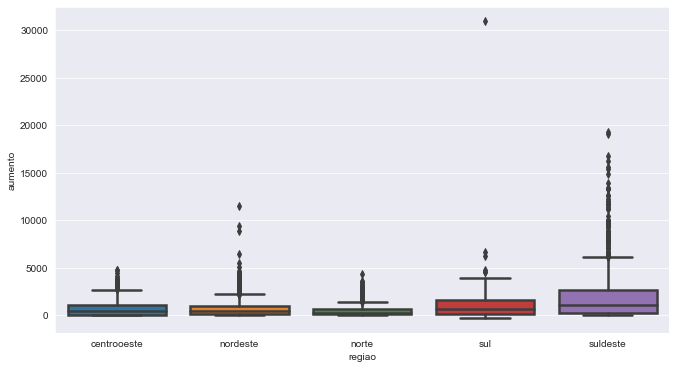

In [8]:
dt_inicio  = datetime.datetime(2020,1,1)
dt_fim = datetime.datetime(2020,10,31)
f, ax = plt.subplots(figsize=(11,6))

sns.boxplot(x="regiao", y="aumento",
            ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' "))

Localizando dado mais extremo

In [9]:
df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' and aumento > 30000 ")

,regiao,uf,data,aceleracao,aumento,total_dia,mes,dia_da_semana
5293,sul,SC,2020-08-31,30453.0,30913.0,177777,2020-08,Segunda


Verificando dados mais próximos 

In [10]:
_=df_diario_estados[(df_diario_estados.data > datetime.datetime(2020,8,25)) &
                    (df_diario_estados.data < datetime.datetime(2020,9,5))&
                    (df_diario_estados.uf== 'SC')]
_.head(30)[['regiao','uf',
            'dia_da_semana','data',
            'aumento',"total_dia"]].style.bar(subset=['aumento']).format({'aumento':"{:,.2f}"}).hide_index()

regiao,uf,dia_da_semana,data,aumento,total_dia
sul,SC,Quarta,2020-08-26 00:00:00,"1,870.00",137560
sul,SC,Quinta,2020-08-27 00:00:00,"2,078.00",139638
sul,SC,Sexta,2020-08-28 00:00:00,"2,054.00",141692
sul,SC,Sábado,2020-08-29 00:00:00,"4,712.00",146404
sul,SC,Domingo,2020-08-30 00:00:00,460.00,146864
sul,SC,Segunda,2020-08-31 00:00:00,"30,913.00",177777
sul,SC,Terça,2020-09-01 00:00:00,"2,697.00",180474
sul,SC,Quarta,2020-09-02 00:00:00,"2,048.00",182522
sul,SC,Quinta,2020-09-03 00:00:00,"1,682.00",184204
sul,SC,Sexta,2020-09-04 00:00:00,"2,392.00",186596


In [56]:
total_casos_SC = df_diario_estados[(df_diario_estados.uf== 'SC')]['total_dia'].max()
valor_acumulado = df_diario_estados[(df_diario_estados.uf== 'SC')]['aumento'].max()
dias_com_dados =  df_diario_estados[(df_diario_estados.uf== 'SC')]['data'].count()
valor_dissolver = total_casos_SC/dias_com_dados
dias_dissolver = valor_acumulado/(total_casos_SC/dias_com_dados)
print('  Em 31/08/2020 houve confirmados {:,.0f} casos em apenas 1 dia,\ncom um total de {:,.0f} em {:,.0f} dias.'.format(valor_acumulado, total_casos_SC, dias_com_dados))
print("  O que representa uma média de {:,.2f} casos por dia,\ne esse dia sozinho representa {:,.2%} do total.".format(valor_dissolver, valor_acumulado/total_casos_SC))
print("  O ideal seria dissolver os {:,.0f} em {:,.0f} dias anteriores,\nconsiderando a proporção por dias da semana.".format(valor_acumulado, dias_dissolver))
print("  Porém optei por manter-lo pela representatividade do represamento,\ne devido ao prazo de entrega do desafio.")

  Em 31/08/2020 houve confirmados 30,913 casos em apenas 1 dia,
com um total de 268,644 em 239 dias.
  O que representa uma média de 1,124.03 casos por dia,
e esse dia sozinho representa 11.51% do total.
  O ideal seria dissolver os 30,913 em 28 dias anteriores,
considerando a proporção por dias da semana.
  Porém optei por manter-lo pela representatividade do represamento,
e devido ao prazo de entrega do desafio.


##  Calculando médias móveis

In [12]:
_ = df_diario_estados.groupby(['regiao','uf',"data"]).mean()

df_mm_aumento = _.aumento.groupby(level=1).apply(lambda x: x.rolling(7).std() )
df_diario_estados['mm_aumento'] = df_mm_aumento.reset_index()['aumento'].to_numpy()


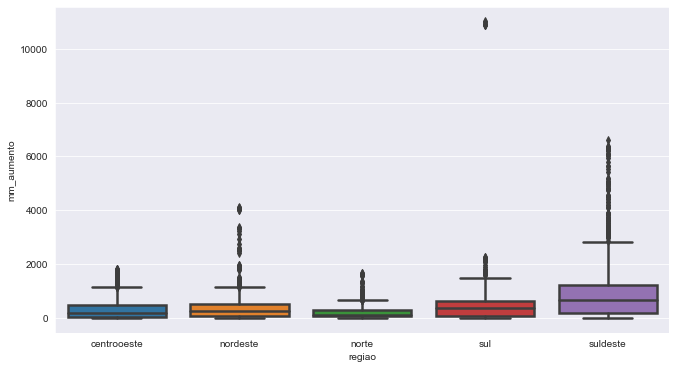

In [13]:
dt_inicio  = datetime.datetime(2020,1,1)
dt_fim = datetime.datetime(2020,10,31)
f, ax = plt.subplots(figsize=(11,6))

sns.boxplot(x="regiao", y="mm_aumento",
            ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11' "))

## Relação População e taxa de infecção

In [15]:
df_ultimo_mes_estado = dados[(dados.tipo_de_local == 'estado') & (dados.ultimo == True) ].copy()
df_ultimo_mes_estado = df_ultimo_mes_estado.groupby('regiao').sum()[['pupolacao_estimada',
                                                                     'confirmacoes']]
df_ultimo_mes_estado["Percentutal infectado da população"] = df_ultimo_mes_estado['confirmacoes']/\
                                                         df_ultimo_mes_estado['pupolacao_estimada']

df_ultimo_mes_estado = df_ultimo_mes_estado.sort_values("Percentutal infectado da população",
                        ascending=False)[['Percentutal infectado da população','pupolacao_estimada']]

df_ultimo_mes_estado = df_ultimo_mes_estado.style.bar(subset=["Percentutal infectado da população",
                                                              'pupolacao_estimada'],color='#CCF')
df_ultimo_mes_estado = df_ultimo_mes_estado.format({"Percentutal infectado da população":"{:.2%}",
                                                   "pupolacao_estimada":"{:,.0f}"})
df_ultimo_mes_estado

,Percentutal infectado da população,pupolacao_estimada
regiao,,
centrooeste,4.27%,"16,504,303"
norte,3.81%,"18,672,591"
nordeste,2.61%,"57,374,243"
sul,2.45%,"30,192,315"
suldeste,2.21%,"89,012,240"


As regiões com menos populações estão com maior percentual da população infectado


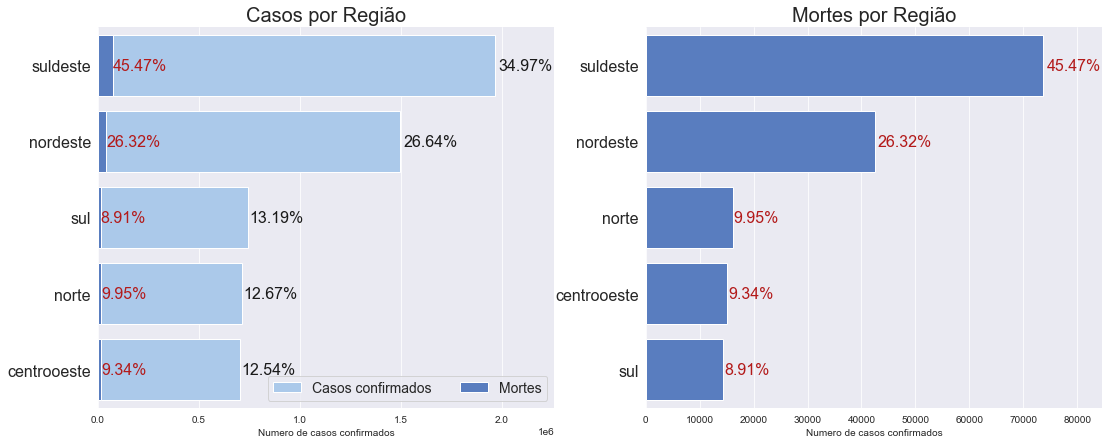

In [16]:
_ = df_slice_estados.query("ultimo == True").groupby(['regiao']).sum()[['confirmacoes','mortes']].reset_index()


_["proporcao_casos"] = _["confirmacoes"]/_.sum()['confirmacoes']
_["proporcao_mortes"] = _["mortes"]/_.sum()['mortes']
_.sort_values('proporcao_casos', ascending=False,inplace=True)

f, ax = plt.subplots(1,2,figsize=(18, 7))

sns.set_color_codes("pastel")
g = sns.barplot(x="confirmacoes", y="regiao", data=_,
            label="Casos confirmados", color="b", ax=ax[0])
sns.set_color_codes("muted")
sns.barplot(x="mortes", y="regiao", data=_,
            label="Mortes", color="b", ax=ax[0])

ax[0].legend(ncol=2, loc="lower right", frameon=True, fontsize=14)
ax[0].tick_params(axis='y', labelsize=16 )
ax[0].set(xlim=(0, _['confirmacoes'].max()*1.15), ylabel="",
       xlabel="Numero de casos confirmados")
ax[0].set_title("Casos por Região", fontsize=20)
sns.despine(left=True, bottom=True)

for i,r in enumerate(_.confirmacoes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_casos.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color='k', va="center", fontsize=16)
for i,r in enumerate(_.mortes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_mortes.to_list()[i]
    g.text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center", fontsize=16)
_.sort_values('proporcao_mortes', ascending=False,inplace=True)   

sns.set_color_codes("muted")
sns.barplot(x="mortes", y="regiao", data=_,
            color="b", ax=ax[1])

ax[1].tick_params(axis='y', labelsize=16 )
ax[1].set(xlim=(0, _['mortes'].max()*1.15), ylabel="",
       xlabel="Numero de casos confirmados")
ax[1].set_title("Mortes por Região", fontsize=20)
sns.despine(left=True, bottom=True)


for i,r in enumerate(_.mortes.to_list()):
    x = r*1.01
    y = i
    v = _.proporcao_mortes.to_list()[i]
    ax[1].text(x,y,"{:.2%}".format(round(v,4)), color=(.7,.1,.1), va="center", fontsize=16)
f.savefig("img/casos_por_REG.png",bbox_inches='tight')

Mais de 60% dos infectados são do nordeste e suldeste as ragiões mais povoadas do Brasil

In [17]:
_ = dados.query("tipo_de_local == 'estado' and regiao in ['suldeste','nordeste'] and ultimo == True").groupby('uf').sum()['confirmacoes'].to_frame().sort_values('confirmacoes', ascending=False)
total = _.sum().squeeze()
_=_.confirmacoes.to_dict()
_["total"]= total
_ = pd.Series(_).to_frame()
_.columns = ['Total casos por região']
_["Percentual"] = _['Total casos por região']/_['Total casos por região'][-1]
_.style.format({'Total casos por região':"{:,.0f}","Percentual":'{:.2%}'})

,Total casos por região,Percentual
SP,"1,125,936",32.54%
MG,"364,541",10.54%
BA,"359,130",10.38%
RJ,"313,843",9.07%
CE,"277,072",8.01%
MA,"186,904",5.40%
PE,"164,222",4.75%
ES,"159,813",4.62%
PB,"134,297",3.88%
PI,"115,825",3.35%


Destes 60% mais de 50% são de 3 estados, ou seja, os estados de SP, MG e BA respondem por 30% dos casos do Brasil inteiro. São Paulo lidera o número de casos isolado com mais 3 vezes mais casos que Minas Gerais em segundo lugar.

## Comportamento em relação ao tempo

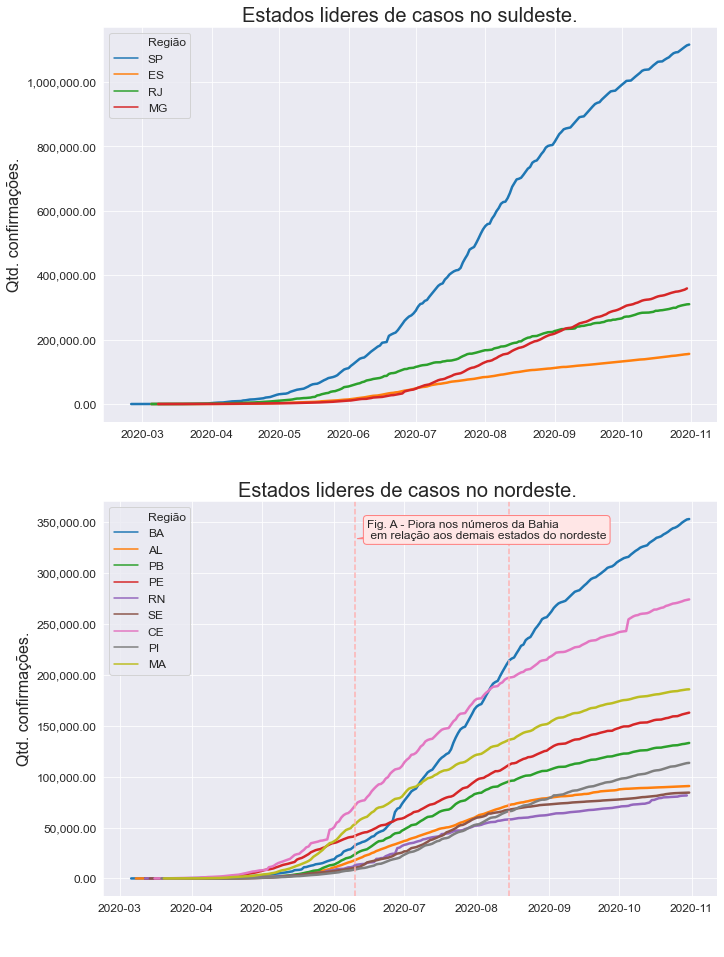

In [55]:
_ = dados.query("tipo_de_local == 'estado' and\
                mes !='2020-11'and\
                regiao in ['suldeste','nordeste']").groupby(["data",
                                                             'uf']).sum()['confirmacoes'].reset_index()
estados_nordeste = set(dados.query("regiao =='nordeste'").uf.to_list())
estados_suldeste = set(dados.query("regiao =='suldeste'").uf.to_list())
y = 'confirmacoes'
y_label = "Qtd. confirmações."
titulo_legenda = 'Região'
titulos = ['Estados lideres de casos no suldeste.',
           'Estados lideres de casos no nordeste. ']

dt_ini_figa = datetime.datetime(2020,6,10)
dt_fim_figa =datetime.datetime(2020,8,15)

tuplas_datas = ["",(dt_ini_figa,dt_fim_figa)] 
el = Ellipse((2, -1), 0.5, 0.5)

f, axs = plt.subplots(2,1,figsize=(11,16))

for i,ax in enumerate(axs):
    
    if i == 0:
        sns.lineplot(x="data", y=y,
                 hue="uf",ax = ax,linewidth=2.5,
                 data=_[_.uf.isin(estados_suldeste)])
    else:
        sns.lineplot(x="data", y=y,
                 hue="uf",ax = ax,linewidth=2.5,
                 data=_[_.uf.isin(estados_nordeste)])
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    listaRotulos = list(by_label.keys())
    listaRotulos[0] = titulo_legenda
    ax.legend(by_label.values(),listaRotulos,loc=2, fontsize=12)
    ax.set_xlabel(" \n ", fontsize=16)
    ax.set_title(titulos[i], fontsize=20, pad=5)
    ax.set_ylabel(y_label, fontsize=16)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12 )
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
    if i == 1:
    
        ax.axvline(dt_ini_figa, color = (1.0, 0.7, 0.7), linestyle='--')
        ax.axvline(dt_fim_figa, color = (1.0, 0.7, 0.7), linestyle='--')
        posicao_yanotacao = ax.get_ylim()[-1] *0.9
        ax.annotate('Fig. A - Piora nos números da Bahia \n em relação aos demais estados do nordeste', xy=(dt_ini_figa,posicao_yanotacao),
                       xytext=(dt_ini_figa + datetime.timedelta(days=5) ,posicao_yanotacao),
                       fontsize=12,
                        bbox=dict(boxstyle="round",
                                    fc=(1.0, 0.9, 0.9),
                                    ec=(1., .5, .5)),
                          arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                          fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                          patchA=None,
                                          patchB=el,
                                          relpos=(0.2, 0.8),
                                          connectionstyle="arc3,rad=-0.1")
                      )

f.savefig("img/escalada.png",bbox_inches='tight')

Na Bahia e em Minas Gerais os casos subiram a partir de junho, com uma velocidade que tornou a Bahia a lider de casos na região em menos de 3 meses.

## Sazonalidade

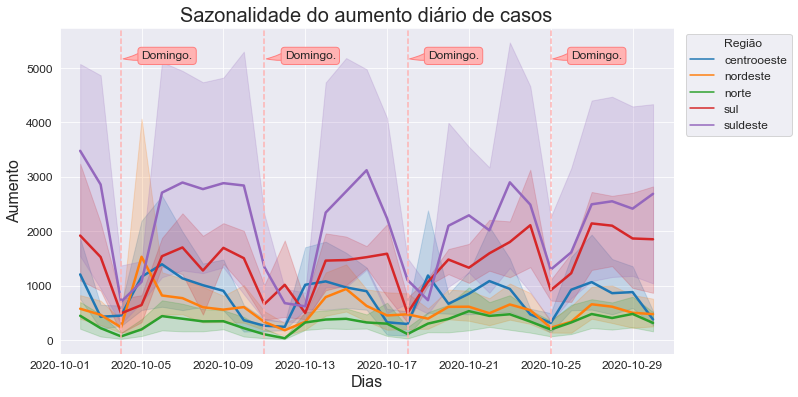

In [31]:
dt_inicio  = datetime.datetime(2020,10,1)
dt_fim = datetime.datetime(2020,10,31)

domingos = df_diario_estados[(dt_inicio < df_diario_estados.data) &
                             (df_diario_estados.data < dt_fim)].query("dia_da_semana == 'Domingo' and uf == 'RR'"
                                                           )['data'].to_list()


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="aumento",
             hue="regiao",ax = ax,linewidth=2.5,
             data=df_diario_estados[(df_diario_estados.data > dt_inicio) &
                                   (df_diario_estados.data < dt_fim) ].query("mes != '2020-11'"))


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos,
          fontsize=12,
          bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("Aumento", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
_ =ax.set_title('Sazonalidade do aumento diário de casos', fontsize=20)
for domingo in domingos:
    ax.axvline(domingo, ymax=250, color = (1.0, 0.7, 0.7), linestyle='--')
    ax.annotate('Domingo.', xy=(domingo,posicao_yanotacao), fontsize=12, 
              xytext=(domingo+ datetime.timedelta(days=1),posicao_yanotacao), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )

É notável a diferença entre o registro de casos no fim de semana e durante a semana


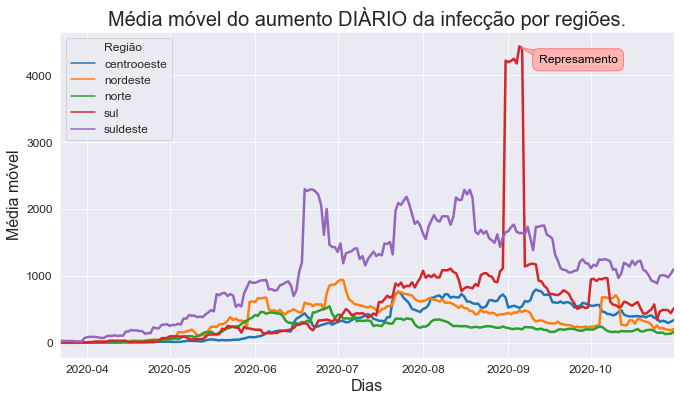

In [20]:
_= df_diario_estados.groupby(["regiao",'data']).mean().reset_index()

dt_inicio  = datetime.datetime(2020,3,22)
dt_fim = datetime.datetime(2020,10,31)

x_seta = _['data'][_.mm_aumento.idxmax()]
y_seta = _['mm_aumento'][_.mm_aumento.idxmax()]
f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="mm_aumento",
             hue="regiao",ax = ax,linewidth=2.5,
             data=_)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos, fontsize=12, loc=2)
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("Média móvel", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
ax.annotate("Represamento", color=(.0,.0,.0),
            xy=(x_seta,y_seta),
            xytext=(x_seta + datetime.timedelta(days=7) ,
                posicao_yanotacao),
            bbox=dict(boxstyle="round", pad=0.5,
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
             arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"),
            fontsize=12)

e_ =ax.set_title('Média móvel do aumento DIÀRIO da infecção por regiões.', fontsize=20)


Aplicando a média móvel de 7 dias foi possível filtar essa sazonalidade e visualizar os represamentos dos casos, que formam essas elevações com o pico plano, pois o valor muito grande, liberado em poucos dias, permanece na média móvel por 7 dias e quando sai os valores voltam à mesma grandeza .

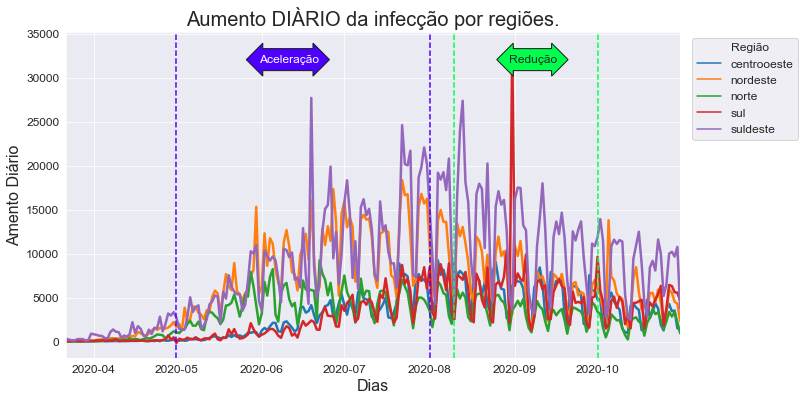

In [36]:
_=df_diario_estados.groupby(["regiao","data"]).sum().reset_index()

dt_inicio  = datetime.datetime(2020,3,22)
dt_fim = datetime.datetime(2020,10,31)
dt_ini_figc  = datetime.datetime(2020,8,10)
dt_fim_figc = datetime.datetime(2020,10,1)
dt_ini_figd  = datetime.datetime(2020,5,1)
dt_fim_figd = datetime.datetime(2020,8,1)


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="aumento",
             hue="regiao",ax = ax,linewidth=2.5,
             data=_)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos, fontsize=12 , bbox_to_anchor=(1.01, 1))
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("Amento Diário", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )
ax.axvline(dt_ini_figc, color = (.0,1.0,.3), linestyle='--')
ax.axvline(dt_fim_figc, color = (.0,1.0,.3), linestyle='--')
ax.annotate('Redução',
            xy=(dt_ini_figc + datetime.timedelta(days=20) ,
                           posicao_yanotacao),
            bbox=dict(boxstyle="DArrow",pad=0.5,
                            fc=(0, 1.0, 0.3),
                            ec='k'),
            fontsize=12)
ax.axvline(dt_ini_figd, color = (.3,0.0,1.0), linestyle='--')
ax.axvline(dt_fim_figd, color = (.3,.0,1.0), linestyle='--')
ax.annotate("Aceleração", color=(1.0,1.0,1.0),
            xy=(dt_ini_figd + datetime.timedelta(days=30) ,
                posicao_yanotacao),
            bbox=dict(boxstyle="DArrow", pad=0.5,
                            fc=(.3,.0,1.0),
                            ec='k'),            
            fontsize=12)

_ =ax.set_title('Aumento DIÀRIO da infecção por regiões.', fontsize=20)


nota se uma redução no aumento diário consistente e em todas as regiões a partir de agosto.

## Região norte 

###  Confirmados por 100 mil

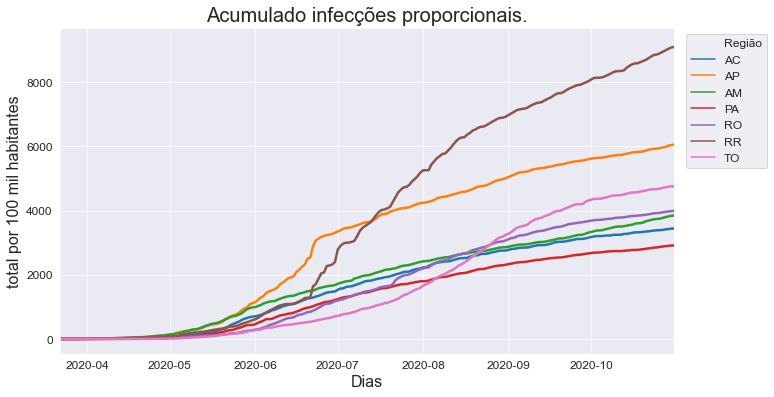

In [46]:
_=df_slice_estados.query("regiao == 'norte'")#.groupby(["uf","data"]).sum().reset_index()

dt_inicio  = datetime.datetime(2020,3,22)
dt_fim = datetime.datetime(2020,10,31)
dt_ini_figc  = datetime.datetime(2020,8,10)
dt_fim_figc = datetime.datetime(2020,10,1)
dt_ini_figd  = datetime.datetime(2020,5,1)
dt_fim_figd = datetime.datetime(2020,8,1)


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="confirmados_por_100k_hab",
             hue="uf",ax = ax,linewidth=2.5,
             data=_)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos, fontsize=12 , bbox_to_anchor=(1.01, 1))
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("total por 100 mil habitantes", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )


_ =ax.set_title('Acumulado infecções proporcionais.', fontsize=20)


### Confirmados total

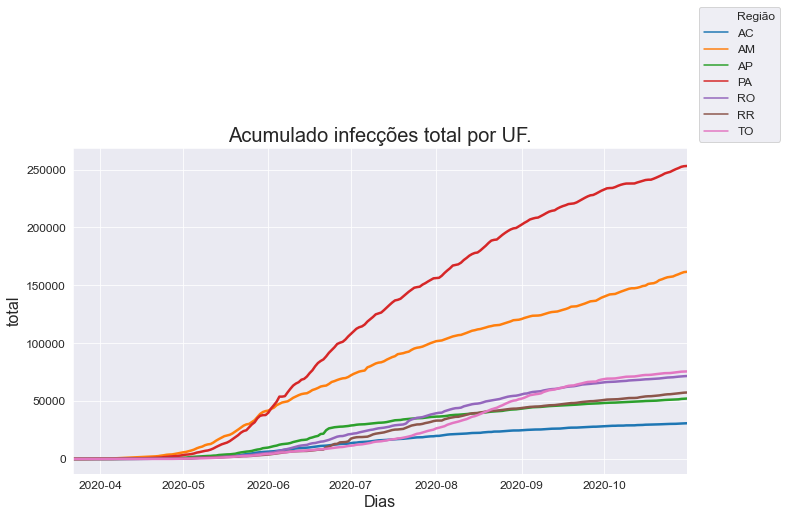

In [51]:
_=df_diario_estados.query("regiao == 'norte'")#.groupby(["uf","data"]).sum().reset_index()

dt_inicio  = datetime.datetime(2020,3,22)
dt_fim = datetime.datetime(2020,10,31)
dt_ini_figc  = datetime.datetime(2020,8,10)
dt_fim_figc = datetime.datetime(2020,10,1)
dt_ini_figd  = datetime.datetime(2020,5,1)
dt_fim_figd = datetime.datetime(2020,8,1)


f, ax = plt.subplots(figsize=(11,6))

sns.lineplot(x="data", y="total_dia",
             hue="uf",ax = ax,linewidth=2.5,
             data=_)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
listaRotulos = list(by_label.keys())
listaRotulos[0] = "Região"
ax.legend(by_label.values(),listaRotulos, fontsize=12 , bbox_to_anchor=(1.01, 1))
ax.set_xlabel("Dias", fontsize=16)
ax.set_ylabel("total", fontsize=16)
ax.set_xlim(dt_inicio,dt_fim)
posicao_yanotacao = ax.get_ylim()[-1] *0.9
ax.tick_params(axis='y', labelsize=12 )
ax.tick_params(axis='x', labelsize=12 )


_ =ax.set_title('Acumulado infecções total por UF.', fontsize=20)


###  Análise das tendências por médias móveis

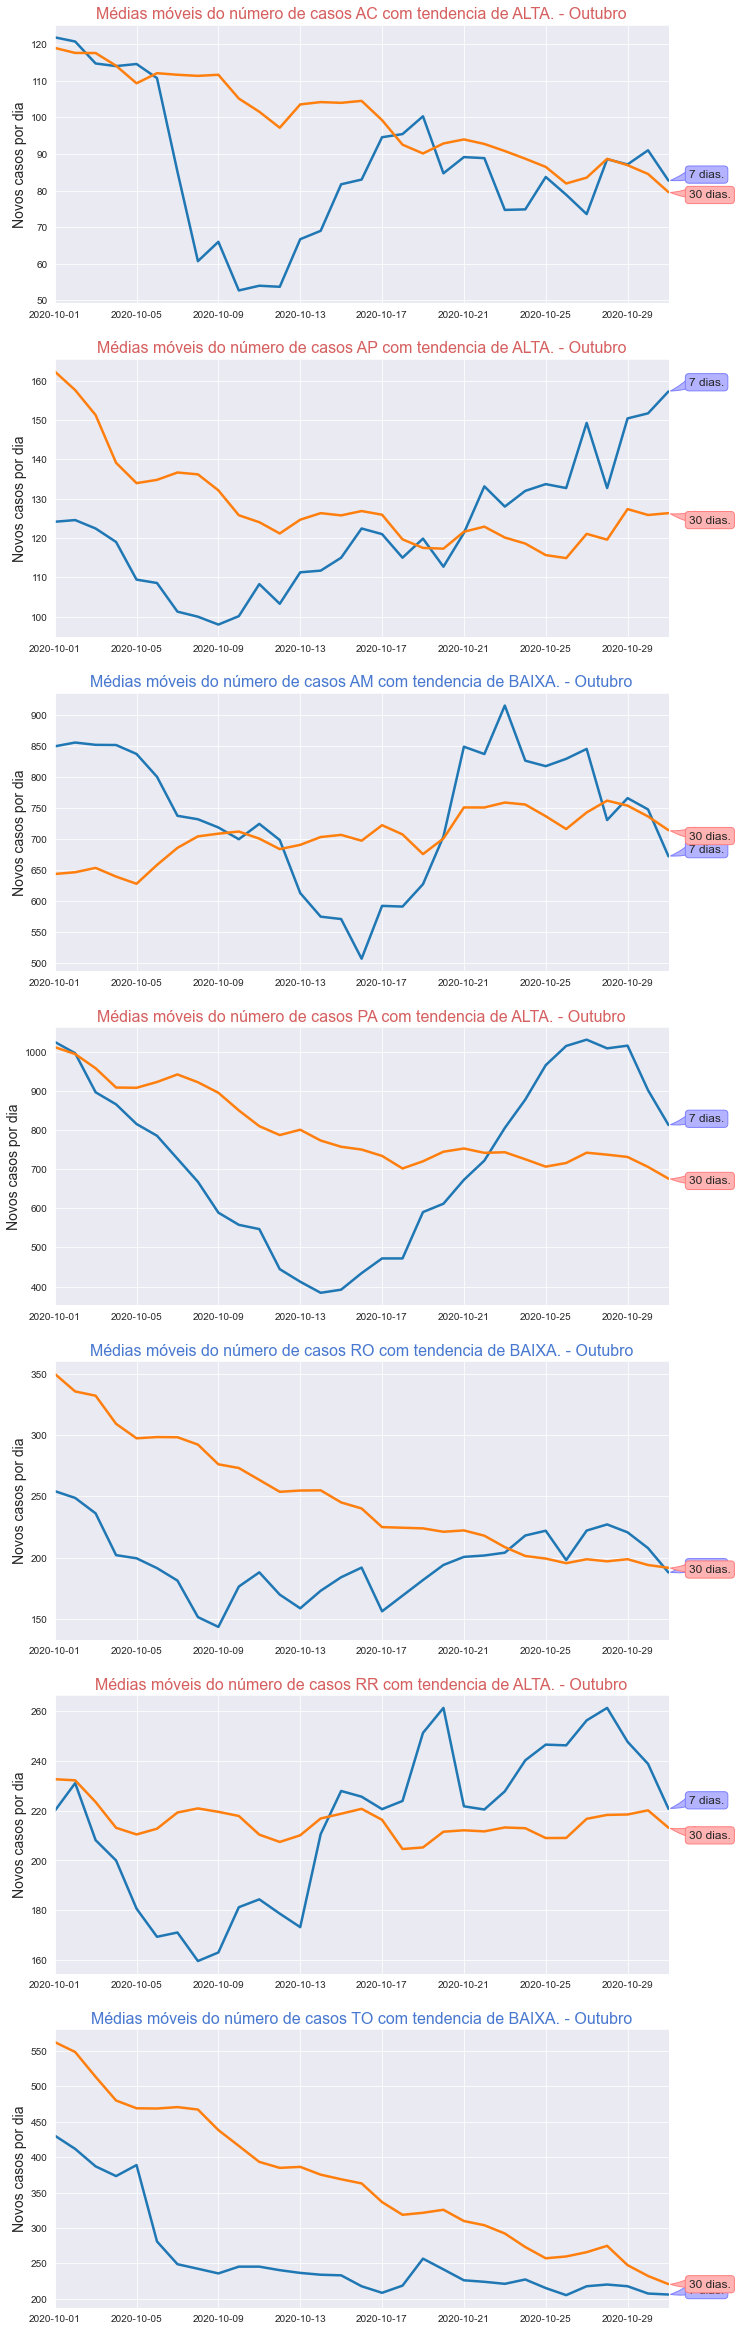

In [32]:
_ = df_slice_estados.query("regiao == 'norte'").uf.unique()
dt_inicio = datetime.datetime(2020,10,1)
dt_fim = datetime.datetime(2020,10,31)

lista_series = []
for UF in _:
    df_estado = df_slice_estados.query("uf =='"+UF+"'").sort_values(['uf','data']).confirmacoes.diff()
    lista_series.append(df_estado)
df_slice_estados['novos_casos']= pd.concat(lista_series)
sr_MM_7 = df_slice_estados.sort_values(['uf','data']).novos_casos.rolling(7).mean()
sr_MM_30 = df_slice_estados.sort_values(['uf','data']).novos_casos.rolling(30).mean()
df_RJ = df_slice_estados.sort_values(['uf','data']).copy()
df_RJ['media_7_dias'] = sr_MM_7
df_RJ['media_30_dias'] = sr_MM_30

qtd = len(_)
f, ax = plt.subplots(qtd,1,figsize=(11,6*qtd))
for i,UF in enumerate(_):
    data = df_RJ.query("uf =='"+UF+"'")
    data = data[(data.data>=dt_inicio) &( data.data<=dt_fim)]
    x_position = data['data'].to_list()[-1]
    y_7dias = data['media_7_dias'].to_list()[-1]
    y_14dias = data['media_30_dias'].to_list()[-1]
    sns.lineplot(x="data", y="media_7_dias", palette="tab10",
             linewidth=2.5,
             data=data, ax=ax[i])
    sns.lineplot(x="data", y="media_30_dias",              linewidth=2.5,
             data=data, ax=ax[i])
    if y_7dias > y_14dias:
        tendencia = "ALTA."
        cor = 'r'
    else:
        tendencia = "BAIXA."
        cor = 'b'
    ax[i].set_title("Médias móveis do número de casos "+UF+" com tendencia de "+tendencia+" - Outubro",fontsize=16, color=cor)
    ax[i].set_xlim(dt_inicio,dt_fim)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Novos casos por dia", fontsize=14)
    ax[i].annotate('7 dias.', xy=(x_position,y_7dias), fontsize=12, 
              xytext=(x_position + datetime.timedelta(days=1),y_7dias*1.01), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(0.7, 0.7, 1),
                            ec=(.5, .5, 1)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(0.7, 0.7, 1), ec=(.5, .5, 1),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )
    
    ax[i].annotate('30 dias.', xy=(x_position,y_14dias), fontsize=12, 
              xytext=(x_position + datetime.timedelta(days=1),y_14dias*.98), #arrowprops=dict(facecolor='k')
               bbox=dict(boxstyle="round",
                            fc=(1.0, 0.7, 0.7),
                            ec=(1., .5, .5)),
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  fc=(1.0, 0.7, 0.7), ec=(1., .5, .5),
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1")
               )

## Fronteiras do norte

In [52]:
cidades_roraima = dados[(dados.uf == 'RR') & (dados.tipo_de_local == 'cidade')].copy()

cidades_roraima['mes'] =cidades_roraima.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )

_ = cidades_roraima.query("mes == '2020-11'").groupby(['municipio']).mean()['confirmados_por_100k_hab'].to_frame().reset_index()
_ = _.query("confirmados_por_100k_hab > 7500").sort_values('confirmados_por_100k_hab', ascending=False)
_.index = _.municipio
del _['municipio']
_.columns = ['Confirmados']
print("Municípios de Roraima com mais de 7500 casos por 100 mil habitantes em novembro")
_

Municípios de Roraima com mais de 7500 casos por 100 mil habitantes em novembro


,Confirmados
municipio,
Boa Vista,10256.355267
São João da Baliza,10247.963585
Caroebe,9645.574495
Uiramutã,8879.414220
Pacaraima,8684.502725
Bonfim,7850.203073


<img src="img/roraima.png"/>

In [53]:
cidades_amapa = dados[(dados.uf == 'AP') & (dados.tipo_de_local == 'cidade')].copy()

cidades_amapa['mes'] =cidades_amapa.data.apply(lambda x:str(x.year)+"-"+str(x.month).zfill(2) )

_ = cidades_amapa.query("mes == '2020-11'").groupby(['municipio']).mean()['confirmados_por_100k_hab'].to_frame().reset_index()
_ = _.query("confirmados_por_100k_hab > 7500").sort_values('confirmados_por_100k_hab', ascending=False)
_.index = _.municipio
del _['municipio']
_.columns = ['Confirmados']
print("Municípios de Amapá com mais de 7500 casos por 100 mil habitantes em novembro")
_

Municípios de Amapá com mais de 7500 casos por 100 mil habitantes em novembro


,Confirmados
municipio,
Vitória do Jari,17903.285350
Pedra Branca do Amapari,16441.085140
Serra do Navio,12700.437320
Calçoene,10604.988505
Oiapoque,10524.618365
Cutias,10162.268480
Laranjal do Jari,9311.358590
Amapá,8566.452600
Santana,8154.204850


<img src="img/amapa.png"/>

<h6>Municípios próximos as fronteiras abertas ou a capital foram os mais afetados em Roraima</h6>

- Em 10/03/2020 a Guiana regista primeiro caso de COVID-19 (**fonte:** [Wikipédia](https://pt.wikipedia.org/wiki/Pandemia_de_COVID-19_na_Guiana))
- Em 18/03/2020, ocorre o fechamento da fronteira de Pacaraima-RR com a Venezuela (**fonte:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/18/fronteira-do-brasil-com-a-venezuela-e-fechada.ghtml
))
- Em 19/03/2020, 9 dias depois do primeiro caso registrado na região, ocorre o fechamento das fronteiras com a Guiana,Guiana Francesa e Suriname. (**fontes:** [G1](https://g1.globo.com/rr/roraima/noticia/2020/03/19/brasil-fecha-fronteira-com-a-guiana.ghtml) / [Veja](https://veja.abril.com.br/mundo/brasil-fecha-fronteiras-com-8-paises-da-america-do-sul/))
